<a href="https://colab.research.google.com/github/MattiaPerrone123/Protein_Family_Prediction/blob/main/Protein_Family_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Protein Family Prediction**

This project is about predicting which families different proteins belong starting from features available in the Protein Data Bank (PDB). In the first part, this task has been accomplished using an LSTM trained on protein amino acids sequences, while in the second part, machine learning classification models, trained on a dataset including protein biophysical properties, were implemented 


#Importing the dataset and libraries

The following libraries, with the respective versions, have been used for this projects:
- numpy==1.21.6
- pandas==1.3.5
- matplotlib==3.2.2
- seaborn==0.11.2
- scikit-learn==1.0.2
- xgboost==0.90

The package keras-tuner (Version 1.1.3) has been used to perform hyperparameter tuning

In [ ]:
import pandas as pd

import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier

from xgboost import XGBClassifier

import pickle
from google.colab import drive

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 7.7 MB/s 
     |████████████████████████████████| 1.6 MB 48.1 MB/s 


In [ ]:
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense, InputLayer, Flatten, Dropout
from keras.layers import LSTM, Embedding
from keras import Input, Model

from keras import backend as K
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

#Part 1

##1) Dataset loading and initial preprocessing

Two datasets from the protein data bank are used for this project. One of the two datasets includes different protein biological properties as features (part 2), while the other one includes the sequence of aminoacids that make up proteins (part 1).

The two datasets have been merged using the feature structureId, i.e. the identification label, as key. Duplicates - meaning protein with the same structureId, have been dropped and this dataset has been used for both parts of the projects. 

In this way, both the machine learning and the deep learning model are trained on the same dataset, even though the features used for the training are different.


In [ ]:
#1) Dataset loading and initial preprocessing

#Loading the dataset
def load_data(path1, path2):
  data1 = pd.read_csv(path1)
  data2 = pd.read_csv(path2)
  return data1, data2 

data1, data2 = load_data('Dataset/pdb_data_no_dups.csv',
                        'Dataset/pdb_data_seq.csv')


#Merging the two datasets and dropping duplicates (according to the feature "structureId")
def merge_and_drop_duplicates_id(data1, data2): 
  data=pd.merge(data1, data2, on=["structureId"]) 
  data.drop_duplicates(subset=['structureId'], inplace=True)
  return data

data_merged = merge_and_drop_duplicates_id(data1, data2)

Just three among all the different protein classes have been selected. These three classes are hydrolase, transferase and oxidoreductase.

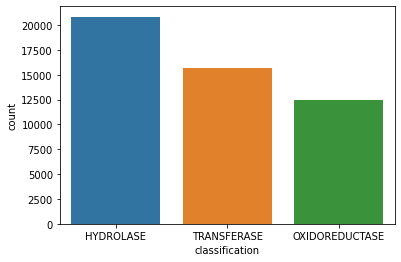

In [ ]:
#Selection of the most common 3 classes of the output variable
def classes_selection(data):
  classes = ['HYDROLASE', 'TRANSFERASE', 'OXIDOREDUCTASE']
  data = data[data.classification.isin(classes)]
  ax=sns.countplot(x=data["classification"])
  data.replace({"HYDROLASE":0,"TRANSFERASE":1,"OXIDOREDUCTASE":2},inplace=True)
  return data 

data_final = classes_selection(data_merged) 

##2) Main preprocessing

Some preprocessing is required before giving the data in input to the model. 

The dataset used for the DL part includes proteins having the same amino acids sequence, but different structureId. In this part of the project, these proteins are duplicated values, and so they have to be dropped. On the other hand, in the ML part of the project, these can be considered as different proteins, since they have different features (such as pH value, crystallization temperature...). 


In [ ]:
#2) Main preprocessing

#Dropping duplicates according to sequence 
def dropping_duplicates_sequences(data):
  data.drop_duplicates(subset='sequence', inplace=True)
  data=data[["classification","sequence"]]
  data.dropna(subset=["sequence"], inplace=True)
  return data

data_final=dropping_duplicates_sequences(data_final)  

Before giving in input sequence data to the LSTM, these sequences have to be all of the same length. The code below is used to have an idea of the lengths of all the proteins included in the dataset.


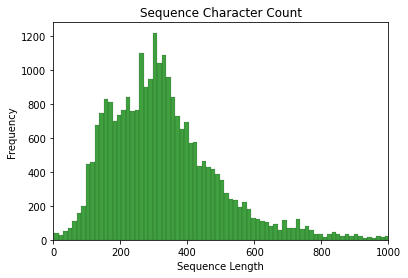

In [ ]:
#Plotting lengths sequences of proteins
def plot_sequence_count(data_final, path):
    sequences=data_final.sequence.values

    val_lengths=[]
    for i in range(len(sequences)): 
      val_lengths.append(len(sequences[i]))

    sns.histplot(val_lengths, color='g')
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.title('Sequence Character Count')
    plt.xlim(0,1000)
    
    plt.savefig(path+"/Sequence Character Count.png")

    return sequences, val_lengths

path="Images"
sequences, lengths=plot_sequence_count(data_final, path)        

The function below is used to convert the amino acids sequnces into a numeric input that can be correctly read by the LSTM. 

A cut-off of 350 amino acids has been established, according to the graph above. If a sequence is longer than this threshold, just the first 350 amino acids are considered for that sequence, while if a sequence is shorter, zero padding is performed.

Also, data cleaning is performed in the function below. This consists in deleting all the observations having "u", "x", "z", "b", "o" as amino acids in their sequences, beacuse these amino acids do not actually exists. This lead to a dataset reduction of 3%.


In [ ]:
#Conversion of amino acids sequences into an integer matrix (x)
def conv_to_matrix_and_delete_wrong_measur(max_length, lengths, sequences): 
  tokenizer = Tokenizer(char_level=True)
  tokenizer.fit_on_texts(sequences)
  x_seq = tokenizer.texts_to_sequences(sequences)
  x = pad_sequences(x_seq, maxlen=max_length)

  final=np.arange(x.shape[0])
  values_kept=[]
  wrong_letters=5
  index_row=row=0
  for index_row in final: 
    if (tokenizer.word_index["u"] in x[row,:]) or \
       (tokenizer.word_index["x"] in x[row,:]) or \
       (tokenizer.word_index["z"] in x[row,:]) or \
       (tokenizer.word_index["b"] in x[row,:]) or \
       (tokenizer.word_index["o"] in x[row,:]):
       x=np.delete(x, (row), axis=0)
       row=row-1
    else:
      values_kept.append(index_row)
    row=row+1   
  
  wrong_letters = 5
  length_dict = len(tokenizer.word_index) - wrong_letters

  return x, values_kept, length_dict, max_length

x, values_kept, length_dict, max_length = conv_to_matrix_and_delete_wrong_measur(350,
                                                      lengths, sequences)  

In the code below, both label_encoding for the output variable and dataset splitting is performed. Data were divided into training (60%), validation (20%) and test set (20%).


In [ ]:
#One hot encoding of the output variable and dataset splitting
def ohe_and_dataset_splitting(x, data, values_kept):
  lb = LabelBinarizer()
  y=data["classification"].iloc[values_kept]
  y=lb.fit_transform(y)

  x, x_test, y, y_test = train_test_split(x,y, test_size=0.2, random_state=15)
  x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=0.25, random_state=15)

  return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = ohe_and_dataset_splitting(x, 
                                                        data_final, values_kept)  

##3) Metrics

In the following script the metric used for the current analysis, which is the f1-score, is defined. The f1-score is chosen as metric since the 3 classes are a bit imbalanced

In [ ]:
#Macro F1-score
def recall(y_true, y_pred):
    y_true = y_true [:,0] 
    y_pred = y_pred [:,0]
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_v = true_positives / (possible_positives + K.epsilon()) 
    return recall_v

def precision(y_true, y_pred):
    y_true = y_true [:,0]
    y_pred = y_pred [:,0]
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_v = true_positives / (predicted_positives + K.epsilon())  
    return precision_v

def f1score(y_true, y_pred):
    precision_v = precision(y_true, y_pred)
    recall_v = recall(y_true, y_pred)
    return 2*((precision_v*recall_v)/(precision_v+recall_v+K.epsilon()))

##4) Hyperparameter tuning

Hyperparameter tuning was performed on the validation set using Hyperband (Li et al. 2019).

The hyperparameters tuned were the number of units in the LSTM layer, the dropout rate in the dropout layer, the learning rate and the number of units in the first dense layer. 

Holdout validation was used for hyperparameter tuning.


In [ ]:
def build_hypermodel(hp):
        model = keras.Sequential()

        model.add(keras.layers.Input(shape = max_length))
        model.add(keras.layers.Embedding(input_dim=length_dict+1, output_dim=128,
              input_length=max_length))
        model.add(keras.layers.LSTM(hp.Int("LSTM_units", min_value=32, max_value=128, 
                                step=32), return_sequences=True))
        
        model.add(keras.layers.Dropout(rate = hp.Float("Dropout", min_value=0.2,
                                               max_value=0.6, step=0.2)))
        model.add(keras.layers.Flatten())

        model.add(Dense(hp.Int("Dense_layer", min_value=300, 
                             max_value=3000, step=300), activation='sigmoid'))
        
        model.add(Dense(3, activation='softmax'))

        hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0001])

        model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=hp_learning_rate),
                metrics=[f1score])
                
        return model


#Setting the objective and the maximum number of epochs
tuner = kt.Hyperband(build_hypermodel,
                     objective=kt.Objective("val_f1score", direction="max"),
                     max_epochs=10, seed=15)

#Setting early stopping set after 5 epochs
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_f1score', patience=5)

#Performing hyperparameters search
tuner.search(x_train, y_train, validation_data=(x_val, y_val),
              epochs=10, callbacks=[stop_early])

#Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best number of LSTM units: {best_hps.get('LSTM_units')}
Best learning rate: {best_hps.get('learning_rate')}
Best dropout value: {best_hps.get('Dropout')}
Best number of units in the first densely-connected layer is:
{best_hps.get('Dense_layer')}
""")

Trial 30 Complete [00h 03m 25s]
val_f1score: 0.7113499641418457

Best val_f1score So Far: 0.732283890247345
Total elapsed time: 00h 35m 46s

Best number of LSTM units: 128
Best learning rate: 0.001
Best dropout value: 0.4
Best number of units in the first densely-connected layer is:
1800



The best Hyperparameters given in output by the code above are provided here, so that hyperparameter tuning does not have to be performed every time.

In [ ]:
best_hps={}
best_hps['LSTM_units']=128
best_hps['learning_rate']=0.001
best_hps['Dropout']=0.4
best_hps['Dense_layer']=1800

##5) Model

The code below includes the LSTM model implemented in keras. 

The structure of the model was taken from the paper by Vazhayil et al. (see reference in the folder References). This structure includes:
- an input layer
- an embedding layer
- an LSTM layer
- a flatten layer
- a dropout layer
- a dense layer (first)
- a dense layer (second), which is also the output layer

More detailed information on these layers are provided in the model summary below.

Moreover:
- The output dimension of the embedding layer is set to 128
- The loss function chosen is categorical cross-entropy
- Adam optimizer was chosen as the optimizer
- Sigmoid and softmax were chosen as activation functions of the first and second dense layer
- The model was trained on 50 epochs


In [ ]:
class LSTM_model(keras.layers.Layer):
    def __init__(self, input_shape, embedding_dim, length_dict, dropout_rate,
                 LSTM_units, dense_layer_1, dense_layer_2):
        self.input_layer = Input(shape = input_shape)
        self.embedding = Embedding(input_dim=length_dict+1, output_dim=embedding_dim,
              input_length=input_shape)
        self.LSTM = LSTM(LSTM_units, return_sequences=True) 
        self.flatten = Flatten()
        self.dropout = Dropout(rate = dropout_rate)
        self.dense_1 = Dense(dense_layer_1, activation='sigmoid')
        self.dense_2 = Dense(dense_layer_2, activation='softmax')

    def call(self, X_input):
        X_input = self.input_layer
        X = self.embedding(X_input)
        X = self.LSTM(X)
        X = self.flatten(X)
        X = self.dropout(X)
        X = self.dense_1(X)
        X = self.dense_2(X)

        model = Model(inputs = X_input, outputs = X)       

        return model



#Giving in input the values found from the hyperparamter search in input to the model
LSTM_model = LSTM_model(input_shape=max_length, embedding_dim=128, length_dict=length_dict,
                      dropout_rate=best_hps.get('Dropout'), LSTM_units=best_hps.get('LSTM_units'),
                      dense_layer_1=best_hps.get('Dense_layer'), dense_layer_2=3)

LSTM_model=LSTM_model.call(X_input=Input(shape = max_length))


def comp_fit_pred(model, loss, learning_rate, metrics, x_train, y_train, x_val,
                       y_val, x_test, n_epochs):
  #Compiling the model
  model.compile(loss=loss, 
                      optimizer=Adam(learning_rate=learning_rate),
                      metrics=[metrics])

  #Fitting the model
  hist=LSTM_model.fit(x_train, y_train, validation_data=(x_val, y_val), 
                      epochs=n_epochs)

  #Making prediction on the test set
  y_pred=model.predict(x_test)

  return hist, y_pred

hist,y_pred_LSTM = comp_fit_pred(LSTM_model, 'categorical_crossentropy', best_hps.get('learning_rate'), 
               f1score, x_train, y_train, x_val, y_val, x_test, 50)

Epoch 1/50
490/490 [==============================] - 27s 40ms/step - loss: 0.9399 - f1score: 0.5755 - val_loss: 0.8366 - val_f1score: 0.6898
Epoch 2/50
490/490 [==============================] - 19s 38ms/step - loss: 0.7846 - f1score: 0.6810 - val_loss: 0.8491 - val_f1score: 0.7009
Epoch 3/50
490/490 [==============================] - 19s 39ms/step - loss: 0.7008 - f1score: 0.7164 - val_loss: 0.8762 - val_f1score: 0.7140
Epoch 4/50
490/490 [==============================] - 19s 38ms/step - loss: 0.6349 - f1score: 0.7537 - val_loss: 0.8014 - val_f1score: 0.6867
Epoch 5/50
490/490 [==============================] - 19s 39ms/step - loss: 0.5611 - f1score: 0.7878 - val_loss: 0.8045 - val_f1score: 0.7287
Epoch 6/50
490/490 [==============================] - 19s 38ms/step - loss: 0.5030 - f1score: 0.8063 - val_loss: 0.8065 - val_f1score: 0.7264
Epoch 7/50
490/490 [==============================] - 21s 44ms/step - loss: 0.4354 - f1score: 0.8292 - val_loss: 0.8051 - val_f1score: 0.7336
Epoch 

In [ ]:
LSTM_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 350)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 350, 128)          2688      
                                                                 
 lstm_1 (LSTM)               (None, 350, 128)          131584    
                                                                 
 flatten_1 (Flatten)         (None, 44800)             0         
                                                                 
 dropout_1 (Dropout)         (None, 44800)             0         
                                                                 
 dense_2 (Dense)             (None, 1800)              80641800  
                                                                 
 dense_3 (Dense)             (None, 3)                 5403  

The model, with its weights, is here saved, so that it can be easily loaded without the need of being trained every time.

In [ ]:
#Saving the model
LSTM_model.save('Models/LSTM_model')

In [ ]:
#Loading the model
path='Models/LSTM_model'
LSTM_model=tf.keras.models.load_model(path, custom_objects={'f1score':f1score})

##6) Results

The two parameters considered to evaluate the model performances are the loss function and the f1-score. 

Both parameters conferm the presence of overfitting, since really good values are obtained on the trainig set, while less good values are obtained on the validation set. In particular, this translates into an increase of the validation loss with the number of epochs and a maximum value of roughly 0.8 on the f1-score validation set (even increasing the number of epochs).

The presence of overfitting could also have been predicted by the high number of trainable parameters (over 80.000.000), which makes the model too complex.



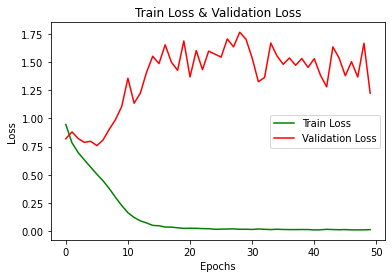

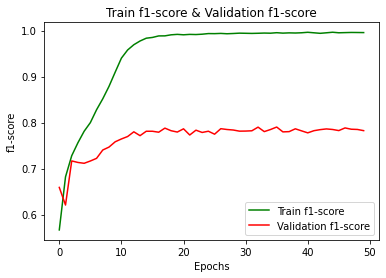

In [ ]:
def plot_LSTM(training_loss, validation_loss, training_f1_score,
              validation_f1_score, path):
  #Loss
  plt.plot(training_loss, c = 'g') 
  plt.plot(validation_loss, c = 'r') 
  plt.legend(['Train Loss','Validation Loss']) 
  plt.title("Train Loss & Validation Loss") 
  plt.xlabel("Epochs") 
  plt.ylabel("Loss")
  plt.savefig(path+'Learning curves Loss.png')
  
  #f1_score
  plt.figure()
  plt.plot(training_f1_score, c = 'g') 
  plt.plot(validation_f1_score, c = 'r')
  plt.legend(['Train f1-score','Validation f1-score']) 
  plt.title("Train f1-score & Validation f1-score") 
  plt.xlabel("Epochs")
  plt.ylabel("f1-score")
  plt.savefig(path+'Learning curves f1-score.png')

path="Images/"

plot_LSTM(hist.history['loss'], hist.history['val_loss'], hist.history['f1score'],
              hist.history['val_f1score'], path)

F1-score on the test set is here computed


In [ ]:
#Calculating f1_score
def F1_score(y_pred, y_test):  
  y_pred_f1=np.argmax(y_pred, axis=1)
  y_test_f1=np.argmax(y_test, axis=1)

  return f1_score(y_pred_f1, y_test_f1, average="macro"), y_pred_f1, y_test_f1

f1_score_LSTM, y_pred_f1, y_test_f1=F1_score(y_pred_LSTM, y_test)  

print("F1_score: ", f1_score_LSTM)

F1_score:  0.7504728256705088


The confusion matrix of the test set is diplayed below. It can be observed that the two classes that are confused more often by the model are hydrolase and transferase, with the model predicting the first one instead of the second one 443 times


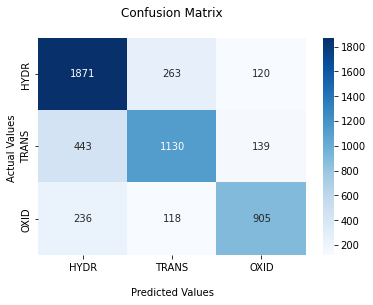

In [ ]:
def conf_matrix(y_test, y_pred, path):
  CM = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  fig = plt.figure()

  labels = ["{0:0.0f}".format(value) for value in
                CM.flatten()]
  labels = np.asarray(labels).reshape(3,3)

  ax = sns.heatmap(CM, annot=labels,fmt='', cmap='Blues')
  ax.set_title('Confusion Matrix\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ax.xaxis.set_ticklabels(["HYDR","TRANS","OXID"])
  ax.yaxis.set_ticklabels(["HYDR","TRANS","OXID"])
  plt.savefig(path+'Confusion matrix.png')
  

path="Images/"
conf_matrix(y_test, y_pred_LSTM, path)

Possible improvements of this part may be an implementation of a simpler model, that would allow for variance reduction. This may translate into increasing the dropout rate and/or the number of dropout layers, to increase regularization, or using a different architecture (i.e. different number of layers/hidden units per layer)

Although there is room for improvement, the results obtained seem to be pretty decent (f1-score 0.75 on the test set)



#Part 2

The second part of the project aims at accomplishing the same task of the first part, which is protein family prediction, but using classical machine learning.

##1) Dataset loading and initial processing

The dataset is loaded using the code below

Mounted at /content/gdrive


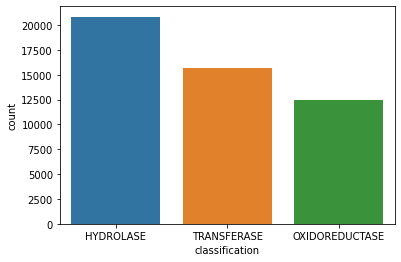

In [ ]:
#Dataset loading is actually not necessary, since the dataset has already been loaded
#in part 1. Here the dataset is loaded just for a clearer presentation of the project

data1, data2 = load_data('/content/gdrive/MyDrive/Protein_Project/pdb_data_no_dups.csv',
                        '/content/gdrive/MyDrive/Protein_Project/pdb_data_seq.csv')

data_merged = merge_and_drop_duplicates_id(data1, data2)

data_final = classes_selection(data_merged)    

##2) Main Preprocessing

Some preprocessing is required before giving the data in input to the models 

###2.1) Categorical variables

The dataset loaded has 48953 observations and 18 features. The number of rows seems to be quite high, unlike the number of features.

6 features were dropped because they are redundant (this is due to the merge of the two datasets) or since they do not provide useful information for protein family prediction.

The preprocessing steps carried out for the categorical variables are summarized below:
- The feature "experimentalTechnique" has 15 different values, with X-ray diffraction being over 90% of the total. Therefore label-encoding just considering two different categories (X-ray diffraction and Other) was performed

- For the feature "macromoleculeType_x" just "Protein" has been selected

- For the feature "crystallization_method" the same procedure described for "experimentalTechnique" has been performed, with the only difference that three different values are considered this time instead of two

In [ ]:
#Dropping duplcated features because of merging and non relevant features
def drop_features(data, feature_1, feature_2, feature_3, feature_4, 
                  feature_5, feature_6):
  if feature_1 in data.columns or feature_2 in data.columns \
      or feature_3 in data.columns or feature_4 in data.columns \
      or feature_5 in data.columns or feature_6 in data.columns:
      data.drop([feature_1, feature_2, feature_3, feature_4,
               feature_5, feature_6], axis=1, inplace=True)
      
drop_features(data_final, "residueCount_y", "macromoleculeType_y", "pdbxDetails",
              "chainId", "publicationYear", "sequence")

#Dividing the values of the feature experimental_technique in just two classes (0 and 1)
def experim_techn(data, feature_1, label_1):
  if type(data[feature_1].iloc[0])!=np.int64:
    xray=data==label_1
    xray_int=xray.astype(np.int64)
    data[feature_1]=xray_int[feature_1] 

experim_techn(data_final, "experimentalTechnique","X-RAY DIFFRACTION") 

#Selection of just proteins
def macromol_type(data, feature_1, label_1):
  if feature_1 in data.columns:
    data = data.loc[data[feature_1] == label_1]
    data.drop([feature_1], axis=1, inplace=True)
  return data

data_final=macromol_type(data_final, "macromoleculeType_x", "Protein") 

#Dividing the values of the feature crystallization_method in just three classes (0,1 and 2)
def cryst_method(data, feature_1, key_1, label_1, label_2):
  if label_1 in data_final.crystallizationMethod.values: 
         han_drop=data[data[feature_1]==label_1]
         han_drop[feature_1]=2

         sit_drop=data[data[feature_1]==label_2]
         sit_drop[feature_1]=1

         Not_na=data[data[feature_1].isna()]

         other = data[(data[feature_1]!=label_1) &\
                      (data[feature_1]!=label_2)&\
                      (data[feature_1].isna()==False)]
         other[feature_1]=0                         

         cryst_new=pd.concat([han_drop,sit_drop,Not_na,other])
         conc=cryst_new[[key_1, feature_1]]

         data=pd.merge(data, conc, on=[key_1])
         data.drop([feature_1+"_x"], axis=1, inplace=True)
         data.rename(columns={feature_1+"_y":feature_1}, inplace=True)
  return data

data_final=cryst_method(data_final, "crystallizationMethod", "structureId", 
                        "VAPOR DIFFUSION, HANGING DROP", "VAPOR DIFFUSION, SITTING DROP")

###2.2) Categorical variables - graphs

Pie charts of the preprocessed variables are displayed below

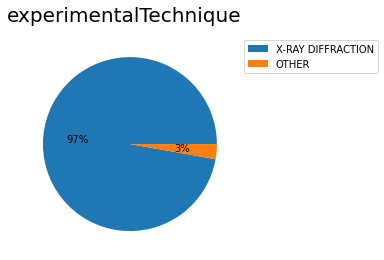

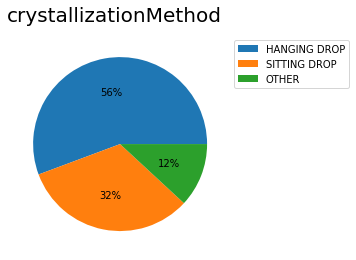

In [ ]:
def graphs_categorical(data, feature_1, feature_2, labels):
  j=0
  feature=[feature_1, feature_2]
  for i in feature:
    fig = plt.figure()
    plt.pie(data[i].value_counts(), autopct='%.0f%%')
    fig.suptitle(i, fontsize=20) 
    plt.legend(labels[j], bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()

    j+=1

graphs_categorical(data_final, "experimentalTechnique", "crystallizationMethod", 
                   [["X-RAY DIFFRACTION","OTHER"],["HANGING DROP","SITTING DROP","OTHER"]])

### 2.3) Numerical variables 

From the boxplot below, we can observe that most of the variables have outliers. This problem will be addressed in section 2.4)


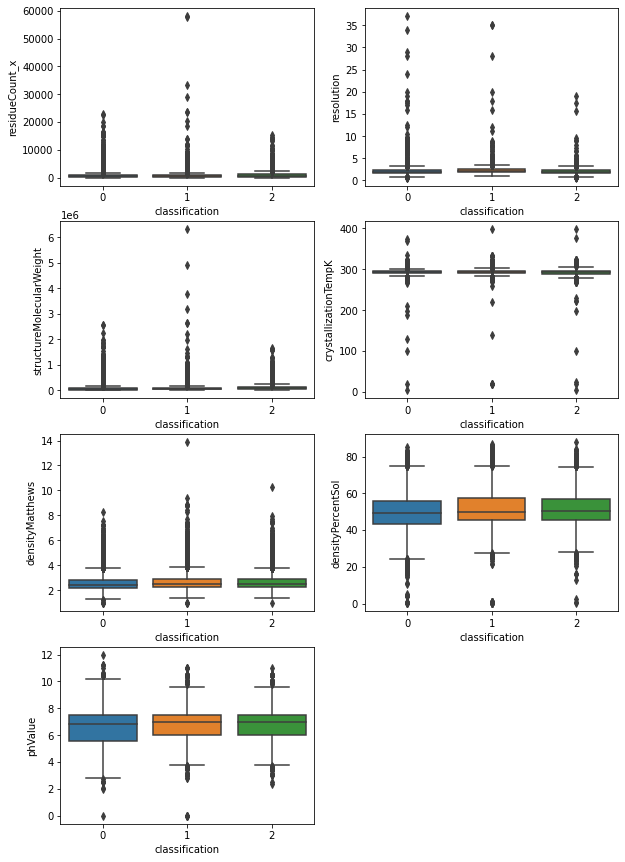

In [ ]:
def graphs_numerical(data, feature_1, feature_2, feature_3, feature_4, feature_5,
                     feature_6, feature_7):
  
  dim_x=4
  dim_y=2
  fig, axs = plt.subplots(dim_x, dim_y, figsize=(10, 15))
  fig.delaxes(axs[dim_x-1,dim_y-1]) 
  feature=[feature_1, feature_2, feature_3, feature_4, feature_5, feature_6, feature_7]
  y_label=["Residue Count","Resolution","Structure Molecular Weight",
           "Crystallization Temp","Density (Matthew)","Density (Percent)", "pH"]
  index=0
  for j in range(dim_x):
    for k in range(dim_y):
        sns.boxplot(x=data["classification"], y=data[feature[index]], 
                data=pd.melt(data), ax=axs[j,k])
        if index<len(feature)-1:
          index+=1


graphs_numerical(data_final, "residueCount_x", "resolution", "structureMolecularWeight",
                 "crystallizationTempK", "densityMatthews", "densityPercentSol","phValue")    

###2.4) Feature engineering

Missing values are imputed using the iterative imputer

In [ ]:
#Imputation (for NaN) 
def imputation(data, feature_imp_round):
  if data.isnull().values.any()==0:
    return
  imp=IterativeImputer(random_state=15)
  data.iloc[:,2:]=imp.fit_transform(data.iloc[:,2:])
  data[feature_imp_round]=data[feature_imp_round].apply(np.round)

imputation(data_final, "crystallizationMethod")

The table below displays the numeric variables with a skewness greater than 0.75 (absolute value).

In [ ]:
def apply_function(data):
  if data.skew().sort_values(ascending=False)[0]<5:
    return -1

def skewness_label(data, skew_limit):
      apply_function(data) 
      skew_vals = data.skew()      
      skew_cols = (skew_vals
                 .sort_values(ascending=False)
                 .to_frame()
                 .rename(columns={0:'Skew'})
                 .query('abs(Skew) > {}'.format(skew_limit)))
    
      display(skew_cols)
      print("")
      

#Skewness before applying np.log()
skew_vals=skewness_label(data_final, 0.75)

,Skew
residueCount_x,12.197076
structureMolecularWeight,10.518877
resolution,8.773001
densityMatthews,2.344911
experimentalTechnique,-5.745857
crystallizationTempK,-11.637733


Positive skewness has been addressed applying the log function to the features. The graph below compares histograms of the variables with positive skewness before and after the log transformation. 

Log transformation wasn't applied also to variables with negative skewness, since this doesn't improve results


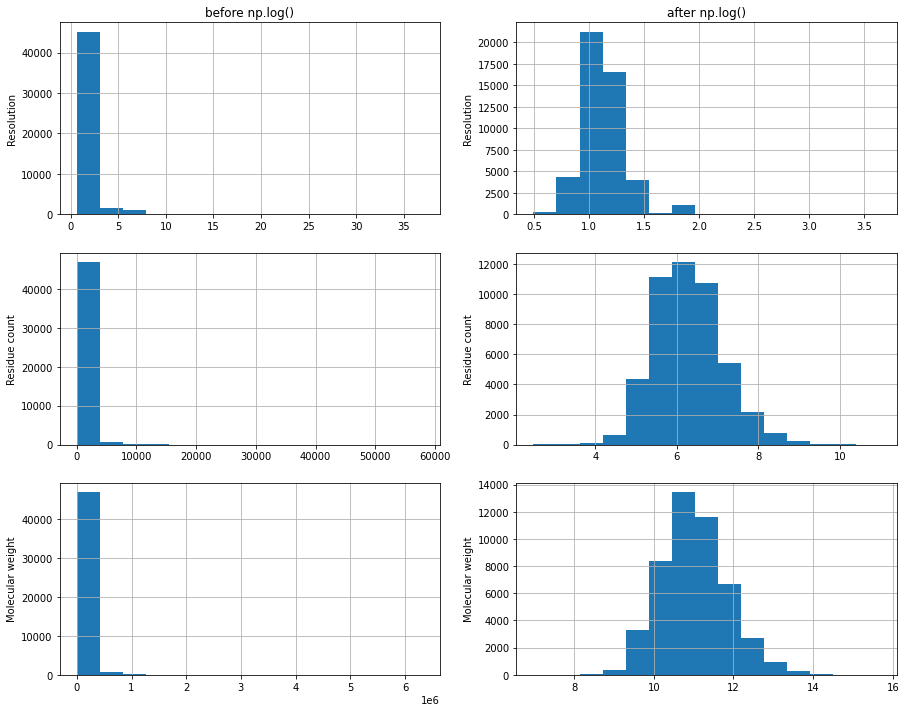

In [ ]:
def skewness_graphs(data, feature_1, feature_2, feature_3, label_1, 
                        label_2, label_3):
      if apply_function(data)==-1:
        return  
      
      j=0
      field = [feature_1, feature_2, feature_3] 
      fig, axs = plt.subplots(3, 2, figsize=(15, 12))

      for i in field:  
        data[i].hist(ax=axs[j,0], bins=15)
        data[i].apply(np.log1p).hist(ax=axs[j,1], bins=15)
        j+=1
      j=0

      label=[label_1, label_2, label_3]

      axs[0,0].set(title='before np.log()')
      axs[0,1].set(title='after np.log()')

      k=0
      for i in label:  
        for j in range(2):
          axs[k,j].set(ylabel=i)
          axs[k,j].set(ylabel=i)
        k+=1


skewness_graphs(data_final, "resolution", "residueCount_x", 
                   "structureMolecularWeight", "Resolution", "Residue count", 
                   "Molecular weight")

The tables below show respectively the skewness of the variables before and after applying log transformation (just to the variables with negative skewness). 

The second table has less element than the first one since, for some features, the skewness dropped below the 0.75 threshold


In [ ]:
#Skewness before applying np.log()
skew_vals=skewness_label(data_final, 0.75)


def skewness_reduction(data, vector):
  if apply_function(data)==-1:
         return 
  for i in vector:
    data[i]=data[i].map(lambda j: np.log(j))

skewness_reduction(data_final, 
                   ["residueCount_x", "structureMolecularWeight", "resolution",
                    "densityMatthews"])



#Skewness after applying np.log()
skewness_label(data_final, 0.75)

,Skew
residueCount_x,12.197076
structureMolecularWeight,10.518877
resolution,8.773001
densityMatthews,2.344911
experimentalTechnique,-5.745857
crystallizationTempK,-11.637733


,Skew
resolution,1.145012
densityMatthews,1.052204
experimentalTechnique,-5.745857
crystallizationTempK,-11.637733


###2.5) Correlation between variables and Dataset splitting

The correlation matrix displayed below shows really low pearson coefficients between features and the output variable. This, combined with the fact that the number of features is very low, will likely lead to low performance on the models trained on this dataset.

The features structureMolecularWeight and residueCount_x are the same (correlation = 1), and also densityMatthews and densityPercentSol are highly correlated. To avoid multicollinearity, one of the two features was dropped in both cases (respectively "structureMolecularWeight" and "densityMatthews")


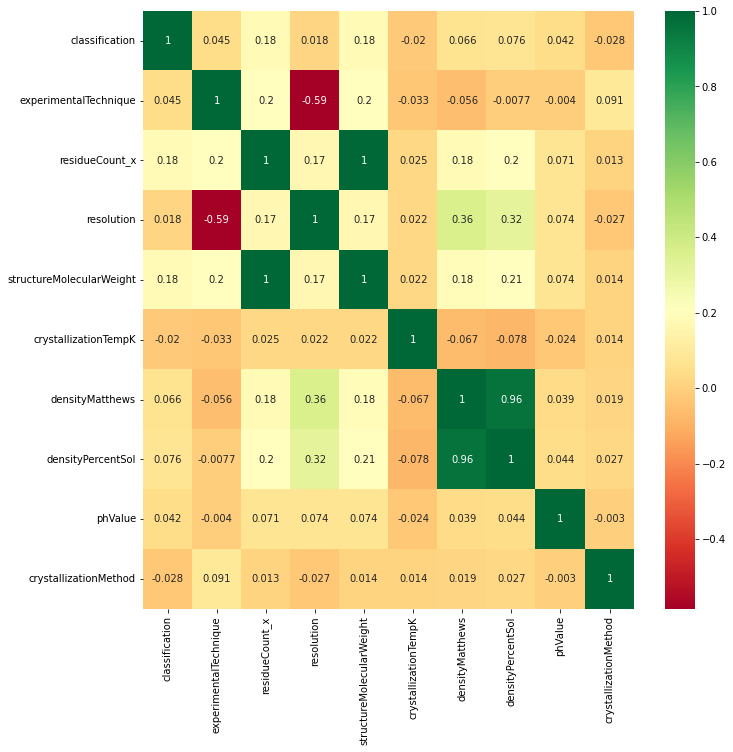

In [ ]:
def correlation(data):
  data_num = data.select_dtypes(include = ['float64', 'int64'])
  data_corr = data_num.corr()['classification'][1:] 
  top_features = data_corr[abs(data_corr) > 0.5].sort_values(ascending=False) 

  plt.figure(figsize=(data.shape[1],data.shape[1]))
  sns.heatmap(data_num.corr(),annot=True,cmap='RdYlGn')
  plt.show()
  
  return top_features

top_corr_features=correlation(data_final)


def drop_features(data, feature_1, feature_2, feature_3):
  if feature_1 in data.columns or feature_2 in data.columns or feature_3 in data.columns:
      data.drop([feature_1, feature_2, feature_3], axis=1, inplace=True)
      
drop_features(data_final,"structureMolecularWeight", "densityMatthews", "structureId")

Dataset splitting has been performed dividing data between training and test set(80% - 20%). Cross-validation (ten splits) has been performed.

In [ ]:
def dataset_splitting(data, output_variable):
  x=data_final.drop([output_variable], axis=1)
  y=data_final[output_variable]

  #Dataset splitting
  x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=15)
  
  #Scaling
  s = StandardScaler()
  x_train_s = s.fit_transform(x_train)
  x_test_s = s.transform(x_test)

  #Cross-validation
  kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=15) 

  return x_train, x_test, y_train, y_test, x_train_s, x_test_s, kf

x_train, x_test, y_train, y_test, x_train_s, x_test_s, kf = dataset_splitting(data_final, "classification")

##3) Models

Four classification models were used to predict protein families starting from the dataset features. These are Decision Trees, Knn, Bagging and XGBoost.
Decision trees were implemented since they are the basic structures for the two ensemble models later implemented, which are bagging and XGBoost. 

For all the four models, the metric used is the macro f1-score. The f1-score is chosen as metric since the 3 classes are a bit imbalanced. Macro f1-score is computed using the arithmetic mean of all the per-class f1 scores.

Finally, since machine learning models were expected to perform worse than deep learning ones, less importance to the hyperparameter tuning of these models has been given (to save time). Therefore, the number of hyperparameters tuned for each model was maximum two. 

###3.1) Decision Trees

For decision trees, the only hyperparameter that has been tuned is the maximum depth of the tree. The graphs reported below represent the mean of the f1-score for the validation set (using cross validation) vs the maximum depth of the trees (first graph) and the mean of the f1-score for the training and test set vs the maximum depth of the trees (second graph).   

The model with the best hyperparameter, chosen through cross-validation, is then saved.


The model with the best F1-score for cross-valdation (0.57) has a max depth of 33
The test F1-score for this model is: 0.59
/content/gdrive/MyDrive/Colab Notebooks/Protein_project/Classification models


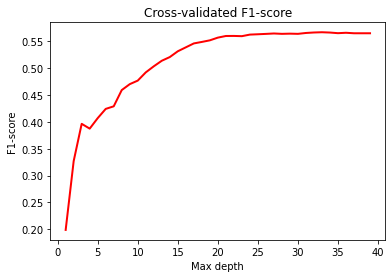

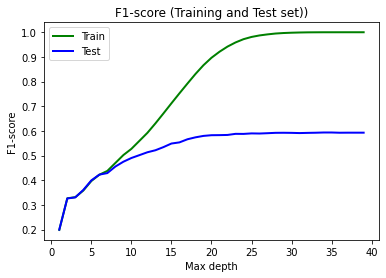

In [ ]:
def decision_trees(x_train_s, x_test_s, y_train, y_test, kf, maximum_depth, path):
  depth_range = range(1, maximum_depth)
  f1_cross_val = []
  f1_test = []
  f1_train = []

  #Hyperparameter tuning (depth) 
  for i in depth_range:
    #Cross-validated f1-score
    tree_clf = DecisionTreeClassifier(max_depth = i, random_state = 15)
    scores = cross_val_score(tree_clf, x_train_s, y_train, cv=kf, scoring='f1_macro')
    f1_cross_val.append(scores.mean())

    #Training and test f1-score
    tree_clf.fit(x_train_s, y_train)
    y_pred_train=tree_clf.predict(x_train_s)
    score_train = f1_score(y_train, y_pred_train, average="macro")
    f1_train.append(score_train)
    y_pred_test=tree_clf.predict(x_test_s)
    score_test = f1_score(y_test, y_pred_test, average="macro")
    f1_test.append(score_test)

  #Graph of Cross-validated f1-score
  plt.plot(depth_range, f1_cross_val,'r', linewidth=2)
  plt.xlabel('Max depth')
  plt.ylabel('F1-score')
  plt.title('Cross-validated F1-score')
  plt.savefig(path+'Cross-validated F1-score.png')

  plt.figure()

  #Graph of train-test f1-score
  plt.plot(depth_range, f1_train, 'g', linewidth=2, label='Train')
  plt.plot(depth_range, f1_test, 'b', linewidth=2, label='Test')
  plt.xlabel('Max depth')
  plt.ylabel('F1-score')
  plt.title('F1-score (Training and Test set))')
  plt.legend(loc="upper left")
  plt.savefig(path+'Train-test F1-score.png')

  result = np.where(f1_cross_val==max(f1_cross_val))
  
  #Training the best model
  tree_model = DecisionTreeClassifier(max_depth = result[0][0]+1, random_state=15)
  tree_model.fit(x_train_s, y_train)

  #Making predictions on the test set
  y_pred=tree_model.predict(x_test_s)

  #Summary
  f1_cross_val_best=round(max(f1_cross_val),2)
  f1_test_best=round(f1_score(y_test,y_pred, average="macro"),2)

  print("The model with the best F1-score for cross-valdation ("+str(f1_cross_val_best)+") has a max depth of " + str(result[0][0]+1))
  print("The test F1-score for this model is:", 
        f1_test_best)

  return tree_model, f1_cross_val_best, f1_test_best



path="Images/"

tree_model, f1_cross_val_best, f1_test_best = decision_trees(x_train_s, x_test_s,
                                                 y_train, y_test, kf, 40, path)


#Saving the model
#%cd /content
%cd gdrive/MyDrive/Colab Notebooks/Protein_project/Classification models
pickle.dump(tree_model, open("Tree_model", "wb")) 
tree_model=pickle.load(open("Tree_model", "rb"))   


###3.2) KNN, Bagging and XGBoost

The following function is used both for the hyperparameter tuning process of Knn, Bagging e XGBoost and for obtaining the results of these three models.

The graphs below display the mean of the f1-score for the training and test set vs each hyperparameter that has been tuned.   

The model with the best hyperparameters, chosen through cross-validation, is then saved.

In [ ]:
def hyperparameters_and_model(x_train_s, x_test_s, 
                          y_train, y_test, kf, hyperparameters, name_model, path):
  k=0
  best_params=[]
  param_ranges=[]
  train_scores=[]
  test_scores=[]


  #Model = KNeighborsClassifier()
  if name_model==BaggingClassifier or name_model==RandomForestClassifier:
    Model=name_model(DecisionTreeClassifier(),random_state=15, bootstrap=True)
  else:
    Model=name_model()

  search = GridSearchCV(Model, hyperparameters, cv=kf, scoring='f1_macro')
  best_model=search.fit(x_train_s,y_train)
  for i in list(hyperparameters.keys()):
    best_params.append(best_model.best_estimator_.get_params()[i])
    param_ranges.append(range(1, hyperparameters[i][-1]+1))

    train_score, test_score = validation_curve(Model, x_train_s, y_train, 
                                                      param_name=list(hyperparameters.keys())[k],
                                                      param_range=param_ranges[k],                                            
                                                      cv=kf, error_score="raise")
    

    train_scores.append(train_score)
    test_scores.append(test_score)

    plt.figure()

    plt.plot(param_ranges[k],np.mean(train_scores[k], axis=1),'g', linewidth=2, label='Train')
    plt.plot(param_ranges[k],np.mean(test_scores[k], axis=1),'b', linewidth=2, label='Test')
    plt.xlabel(str(list(hyperparameters.keys())[k]))
    plt.ylabel('F1-score')
    plt.title('Train-test F1-score')
    plt.legend(bbox_to_anchor=(1.21, 1), loc="upper right")
    plt.savefig(path+str(name_model)+str(k)+'.png') 

    k+=1

  #KNN
  if name_model==KNeighborsClassifier:
    Model_best = name_model(n_neighbors=best_model.best_estimator_.get_params()['n_neighbors'])

  #Bagging
  if name_model==BaggingClassifier:
    Tree=DecisionTreeClassifier(max_depth = best_model.best_params_["base_estimator__max_depth"], random_state=15)
    Model_best = BaggingClassifier(Tree, n_estimators = best_model.best_params_["n_estimators"], random_state=15, bootstrap=True)
    
  #XGBoost
  if name_model==XGBClassifier:
    Model_best = XGBClassifier(n_estimators = best_model.best_params_["n_estimators"], 
                               max_depth = best_model.best_params_["max_depth"],
                               random_state=15, bootstrap=True)

  #Training the best model
  Model_best.fit(x_train_s, y_train)

  #Making predictions on the train and test set
  y_pred_train=Model_best.predict(x_train_s)
  y_pred_test=Model_best.predict(x_test_s)

  #Summary
  f1_train_best=round(f1_score(y_train,y_pred_train, average="macro"),2)
  f1_test_best=round(f1_score(y_test,y_pred_test, average="macro"),2)

  
  print("The train F1-score for the best model is:", 
        f1_train_best)
  print("The test F1-score for the best model is:", 
        f1_test_best)

  
  return Model_best, f1_train_best, f1_test_best, best_params, y_pred_test

path="Images/"          

For Knn, the only hyperparameter considered is n_neighbors. Since the best value of these parameter is 1, overfitting is involved. This is also confirmed by the fact that the training f1-score (1.00) is much higher than the test one (0.57)


The train F1-score for the best model is: 1.0
The test F1-score for the best model is: 0.57
[1]


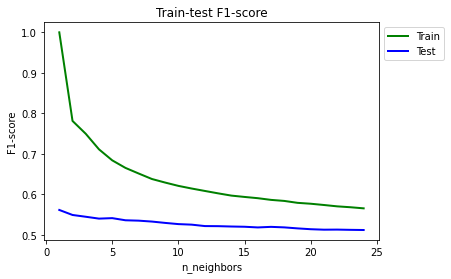

In [ ]:
#KNN
Knn_model, f1_train_best_knn, f1_test_best_knn, best_params_knn, y_pred_test_knn = hyperparameters_and_model(x_train_s, x_test_s, y_train, 
                                  y_test, kf, {'n_neighbors': list(range(1,25))}, 
                                  KNeighborsClassifier, path)
pickle.dump(Knn_model, open("Knn_model", "wb")) #save the model in the current directory
Knn_model=pickle.load(open("Knn_model", "rb")) #load the model
print(best_params_knn)
#Knn_models

For Bagging, the two hyperparameters considered are the number of estimators and the maximum depth of the base estimator used.

As expected, Bagging is able to obtain better results with respect to the ones obtained by Knn and Decision Trees.

The train F1-score for the best model is: 1.0
The test F1-score for the best model is: 0.66
[40, 35]


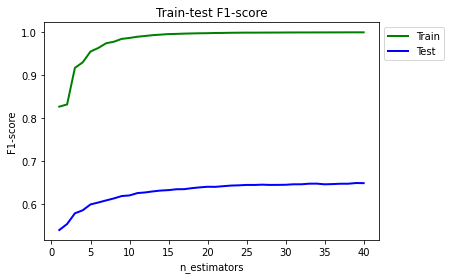

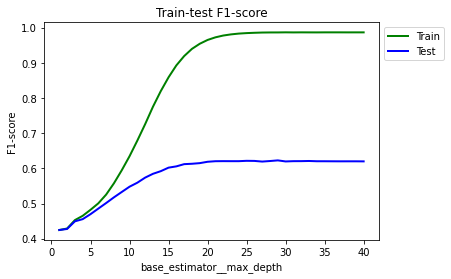

In [ ]:
#Bagging
Bagging_model, f1_train_best_bag, f1_test_best_bag, best_params_bag, y_pred_test_bag = hyperparameters_and_model(x_train_s, x_test_s, y_train, 
                                  y_test, kf,  {'n_estimators': [n for n in range(5,41,5)], 
                                  'base_estimator__max_depth' : [n for n in range(5,41,5)]}, 
                                  BaggingClassifier, path) 

#Saving Bagging model
pickle.dump(Bagging_model, open("Bagging_model", "wb")) #save the model in the current directory
Bagging_model=pickle.load(open("Bagging_model", "rb")) #load the model
print(best_params_bag)
#Bagging_model

For XGBoost, the two hyperparameters considered are the maximum depth of the base estimator used and the number of estimators.

The performance of this model is very similar to bagging's one, being just slightly better.

The train F1-score for the best model is: 1.0
The test F1-score for the best model is: 0.66
[20, 105]


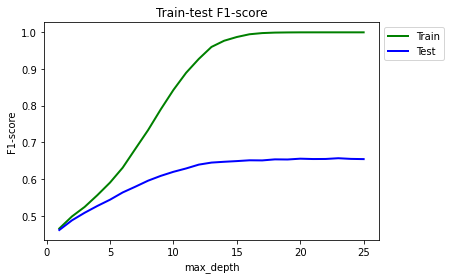

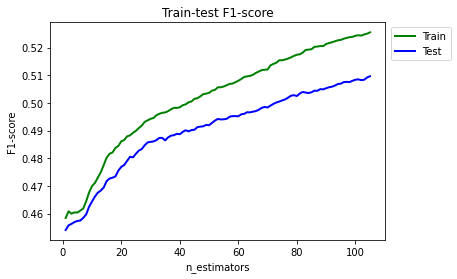

In [ ]:
#XGBoost
XGBoost_model, f1_train_best_XGB, f1_test_best_XGB, best_params_XGB, y_pred_test_XGB = hyperparameters_and_model(x_train_s, x_test_s, y_train, 
                                  y_test, kf, {'max_depth':[n for n in range(5,26,5)],
                                  'n_estimators':[n for n in range(5,121,20)]}, 
                                  XGBClassifier, path) 

#Saving XGBoost
pickle.dump(XGBoost_model, open("XGBoost_model", "wb")) #save the model in the current directory
XGBoost_model=pickle.load(open("XGBoost_model", "rb")) #load the model
print(best_params_XGB)
#XGBoost_model

The four models previoulsy saved are here loaded, so that they don't have to be trained again. 

In [ ]:
#Loading the models
%cd /content
%cd gdrive/MyDrive/Colab Notebooks/Protein_project/Classification models
tree_model=pickle.load(open("Tree_model", "rb")) 
Knn_model=pickle.load(open("Knn_model", "rb"))
Bagging_model=pickle.load(open("Bagging_model", "rb")) 
XGBoost_model=pickle.load(open("XGBoost_model", "rb")) 

##3.3) Evaluation of the models

These section includes the results of the four classification models. The graph below compares the f1-score of these models for the test set.


In [ ]:
#Save the f1-scores (cross-validation) of all the models run (models already saved thanks to pickle)
def model_select(classifier, x_test_s, y_test):
    results=[]
    prediction = classifier.predict(x_test_s)
    results.append(f1_score(prediction, y_test, average="macro"))
    return results
model_type = [Knn_model, tree_model, Bagging_model, XGBoost_model] 
model_score = [model_select(i, x_test_s, y_test) for i in model_type]


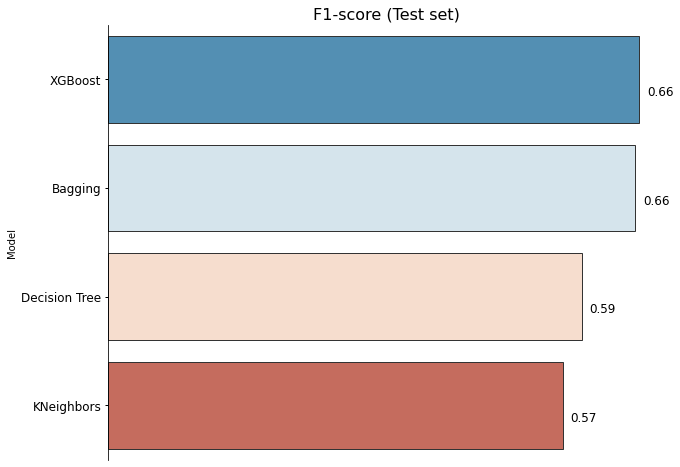

In [ ]:
classifier = ['KNeighbors','Decision Tree',"Bagging","XGBoost"]

ml_model = pd.DataFrame(model_score,classifier).reset_index()
ml_model.columns=['Model','f1_score']
ml_model.sort_values('f1_score',ascending = False,inplace=True)
ml_model.reset_index(drop=True,inplace = True)
f, ax = plt.subplots(figsize=(10,8))
sns.barplot('f1_score','Model',data=ml_model, ax=ax,palette='RdBu_r',edgecolor=".2")
for i in ax.patches:
    ax.text(i.get_width()+.01, i.get_y()+.55, \
        str(round((i.get_width()), 2)), fontsize=12, color='black') 
kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':'large'}
ax.tick_params(**kwargs)
x_axis = ax.axes.get_xaxis().set_visible(False)
ax.set_title('F1-score (Test set)',fontsize=16)
sns.despine(bottom=True)
plt.savefig(path+'score_test_set.png') 

#Credit to HERMANN NJIKE for the graph below (adapted)

F1-score on the test set of the best model (XGBoost) is reported, as well as the confusion matrix for this very same model.


In [ ]:
#Calculating f1_score
def F1_score(y_pred, y_test, model):  
  lb = LabelBinarizer()
  y_test_ohe=lb.fit_transform(y_test)
  y_pred=model.predict(x_test_s)
  y_pred_ohe=lb.fit_transform(y_pred)

  return f1_score(y_pred_ohe, y_test_ohe, average="macro"), y_test_ohe, y_pred_ohe

f1_score_XGB, y_test_ohe, y_pred_XGB_ohe=F1_score(y_pred_test_XGB, y_test, XGBoost_model)  

print("F1_score: ", f1_score_XGB)

F1_score:  0.6647006996241293


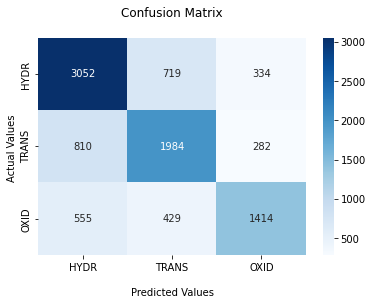

In [ ]:
def conf_matrix(y_test, y_pred):
  CM = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  fig = plt.figure()

  labels = ["{0:0.0f}".format(value) for value in
                CM.flatten()]
  labels = np.asarray(labels).reshape(3,3)

  ax = sns.heatmap(CM, annot=labels,fmt='', cmap='Blues')
  ax.set_title('Confusion Matrix\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ax.xaxis.set_ticklabels(["HYDR","TRANS","OXID"])
  ax.yaxis.set_ticklabels(["HYDR","TRANS","OXID"])
  plt.savefig(path+'conf_matrix_XGB.png') 
  

conf_matrix(y_test_ohe, y_pred_XGB_ohe)

As for the first part of the project, the four classification models overfit the training set. All the four models are indeed able to reach an f1-score equal to 1.00 on the traning set, while the f1-score on the test set is never above 0.66. 

The reason why these models don't perform well on the test set may be related to the specific dataset that has been used for the study (low number of features and low correlation between features and the output variable).

To achieve better results, it would be possible to:
- generate polynomial and/or interaction features
- use another dataset which includes a higher numner of features
